In [85]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

class CustomMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # data directory
        self.transform = transform # 데이터 이미지 스케일 변환
        self.image_paths = []

        for i in range(10):
            label_dir = os.path.join(root_dir, str(i))
            for img_file in glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(img_file) # data 파일에 있는 이미지 파일 저장

        print(f'Found {len(self.image_paths)} images')        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index): # 이미지 스케일 변환
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("L")
        if self.transform is not None:
            image = self.transform(image)
        return image    

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z_dim, feature_g*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.InstanceNorm2d(feature_g*4)
        self.r1 = nn.ReLU(True)

        self.conv2 = nn.ConvTranspose2d(feature_g*4, feature_g, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(feature_g)
        self.r2 = nn.ReLU(True)

        self.conv3 = nn.ConvTranspose2d(feature_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.t = nn.Tanh()

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        conv1_out = x  # 활성화 함수 출력 저장
        x = self.r2(self.bn2(self.conv2(x)))
        conv2_out = x  # 활성화 함수 출력 저장
        x = self.t(self.conv3(x))
        conv3_out = x  # 활성화 함수 출력 저장
        return x, conv1_out, conv2_out, conv3_out

class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(True)

        self.conv2 = nn.Conv2d(feature_d, feature_d*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d*4)
        self.r2 = nn.ReLU(True)

        self.conv3 = nn.Conv2d(feature_d*4, 1, kernel_size=3, stride=2, padding=0, bias=False)
        self.t = nn.Sigmoid()

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        conv1_out = x  # 활성화 함수 출력 저장
        x = self.r2(self.bn2(self.conv2(x)))
        conv2_out = x  # 활성화 함수 출력 저장
        x = self.t(self.conv3(x))
        conv3_out = x  # 활성화 함수 출력 저장
        return x, conv1_out, conv2_out, conv3_out


data_dir = './data/train/'
result_dir = './result/'
os.makedirs(result_dir, exist_ok=True)

# 4. 하이퍼파라미터 정의
batch_size = 64
lr = 0.0001
z_dim = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 20  # 훈련 에포크 수

print(f"Using Device: {device}")

# 5. 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# 6. 데이터셋 및 데이터로더 생성

train_dataset = CustomMNISTDataset(root_dir=data_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# 7. 모델 초기화

gen = Generator(z_dim=z_dim, img_channels=1, feature_g=32).to(device)
disc = Discriminator(img_channels=1, feature_d=32).to(device)

# 8. 최적화 함수 및 손실 함수 정의

opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
bce_loss = nn.BCELoss()

# 9. 생성된 이미지 시각화 함수 정의

def show_generated_images(generator, num_images=64, epoch=0):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)  # CNN은 4D 텐서 입력을 기대
        fake_images, conv1_out, conv2_out, conv3_out = generator(noise)
        
        fake_images = fake_images.cpu()
        grid = vutils.make_grid(fake_images, nrow=8, normalize=True)
        plt.clf()
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Generated Images at Epoch {epoch}')
        plt.savefig(f'{result_dir}image_normalnormal.png', pad_inches=0.1, bbox_inches='tight')
        plt.close()
        plt.show
    generator.train()

# 10. GAN 훈련 루프
losses_g = []
losses_d = []

for epoch in range(epochs):
    for batch_idx, real in enumerate(train_dataloader):
        real = real.to(device)
        batch_size = real.shape[0]
        ### (a) 판별자 훈련 (진짜 이미지)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake, conv1_out_gen, conv2_out_gen, conv3_out_gen = gen(noise)
        
        # 진짜 이미지(1) 판별
        disc_real, conv1_out_disc_real, conv2_out_disc_real, conv3_out_disc_real = disc(real)
        loss_disc_real = bce_loss(disc_real.view(-1), torch.ones_like(disc_real.view(-1)))

        # 가짜 이미지(0) 판별
        disc_fake, conv1_out_disc_fake, conv2_out_disc_fake, conv3_out_disc_fake = disc(fake.detach())
        loss_disc_fake = bce_loss(disc_fake.view(-1), torch.zeros_like(disc_fake.view(-1)))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### (b) 생성자 훈련 (가짜 이미지)
        output, conv1_out_gen, conv2_out_gen, conv3_out_gen = disc(fake)
        loss_gen = bce_loss(output.view(-1), torch.ones_like(output.view(-1)))
        
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        losses_g.append(loss_gen.item())
        losses_d.append(loss_disc.item())
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_dataloader)} "
                  f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
            show_generated_images(gen, num_images=16, epoch=epoch+1)

Using Device: cpu
Found 60000 images
Epoch [1/20] Batch 0/938 Loss D: 0.7414, Loss G: 0.6043
Epoch [1/20] Batch 10/938 Loss D: 0.4739, Loss G: 0.7594
Epoch [1/20] Batch 20/938 Loss D: 0.3420, Loss G: 1.0037
Epoch [1/20] Batch 30/938 Loss D: 0.2948, Loss G: 1.0997
Epoch [1/20] Batch 40/938 Loss D: 0.2482, Loss G: 1.2733
Epoch [1/20] Batch 50/938 Loss D: 0.1630, Loss G: 1.7457
Epoch [1/20] Batch 60/938 Loss D: 0.1667, Loss G: 1.7947
Epoch [1/20] Batch 70/938 Loss D: 0.1200, Loss G: 2.1831
Epoch [1/20] Batch 80/938 Loss D: 0.1160, Loss G: 2.1231
Epoch [1/20] Batch 90/938 Loss D: 0.1043, Loss G: 2.3175
Epoch [1/20] Batch 100/938 Loss D: 0.0600, Loss G: 2.9524
Epoch [1/20] Batch 110/938 Loss D: 0.0581, Loss G: 2.9725
Epoch [1/20] Batch 120/938 Loss D: 0.1040, Loss G: 2.1085
Epoch [1/20] Batch 130/938 Loss D: 0.0882, Loss G: 2.3104
Epoch [1/20] Batch 140/938 Loss D: 0.0768, Loss G: 2.7449
Epoch [1/20] Batch 150/938 Loss D: 0.0617, Loss G: 2.8921
Epoch [1/20] Batch 160/938 Loss D: 0.0566, Los

In [59]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

class CustomMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # data directory
        self.transform = transform # 데이터 이미지 스케일 변환
        self.image_paths = []

        for i in range(10):
            label_dir = os.path.join(root_dir, str(i))
            for img_file in glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(img_file) # data 파일에 있는 이미지 파일 저장

        print(f'Found {len(self.image_paths)} images')        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index): # 이미지 스케일 변환
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("L")
        if self.transform is not None:
            image = self.transform(image)
        return image    

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z_dim, feature_g*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.InstanceNorm2d(feature_g*4)
        self.r1 = nn.ReLU(True)

        self.conv2 = nn.ConvTranspose2d(feature_g*4, feature_g, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(feature_g)
        self.r2 = nn.ReLU(True)

        self.conv3 = nn.ConvTranspose2d(feature_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.t = nn.Tanh()

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.t(self.conv3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(True)

        self.conv2 = nn.Conv2d(feature_d, feature_d*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d*4)
        self.r2 = nn.ReLU(True)

        self.conv3 = nn.Conv2d(feature_d*4, 1, kernel_size=3, stride=2, padding=0, bias=False)

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        return x


data_dir = './data/train/'
result_dir = './result/'
os.makedirs(result_dir, exist_ok=True)

# 4. 하이퍼파라미터 정의
batch_size = 64
lr = 0.0005
z_dim = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 100  # 훈련 에포크 수

print(f"Using Device: {device}")

# 5. 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# 6. 데이터셋 및 데이터로더 생성

train_dataset = CustomMNISTDataset(root_dir=data_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# 7. 모델 초기화

gen = Generator(z_dim=z_dim, img_channels=1, feature_g=32).to(device)
disc = Discriminator(img_channels=1, feature_d=32).to(device)

# 8. 최적화 함수 및 손실 함수 정의

opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr*0.75)
bce_loss = nn.BCEWithLogitsLoss()

# 9. 생성된 이미지 시각화 함수 정의

def show_generated_images(generator, num_images=64, epoch=0):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)  # CNN은 4D 텐서 입력을 기대
        fake_images = generator(noise)
        fake_images = fake_images.cpu()
        grid = vutils.make_grid(fake_images, nrow=8, normalize=True)
        plt.clf()
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Generated Images at Epoch {epoch}')
        plt.savefig(f'{result_dir}image_lr_mod.png', pad_inches=0.1, bbox_inches='tight')
        plt.close()
    generator.train()

# 10. GAN 훈련 루프
losses_g = []
losses_d = []

for epoch in range(epochs):
    for batch_idx, real in enumerate(train_dataloader):
        real = real.to(device)
        batch_size = real.shape[0]
        ### (a) 판별자 훈련 (진짜 이미지)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        
        # 진짜 이미지(1) 판별
        disc_real = disc(real).view(-1) # 이미지 판별 결과
        loss_disc_real = bce_loss(disc_real, torch.ones_like(disc_real))

        # 가짜 이미지(0) 판별
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = bce_loss(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### (b) 생성자 훈련 (가짜 이미지)
        output = disc(fake).view(-1)
        loss_gen = bce_loss(output, torch.ones_like(output))
        
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        losses_g.append(loss_gen.item())
        losses_d.append(loss_disc.item())

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_dataloader)} "
                  f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
            show_generated_images(gen, num_images=16, epoch=epoch+1)

Using Device: cpu
Found 60000 images
Epoch [1/85] Batch 0/938 Loss D: 0.6839, Loss G: 0.7823
Epoch [1/85] Batch 10/938 Loss D: 0.4286, Loss G: 1.0740
Epoch [1/85] Batch 20/938 Loss D: 0.3256, Loss G: 1.8696
Epoch [1/85] Batch 30/938 Loss D: 0.2234, Loss G: 2.2573
Epoch [1/85] Batch 40/938 Loss D: 0.1040, Loss G: 2.9401
Epoch [1/85] Batch 50/938 Loss D: 0.1247, Loss G: 2.3908
Epoch [1/85] Batch 60/938 Loss D: 0.0557, Loss G: 3.3700
Epoch [1/85] Batch 70/938 Loss D: 0.0665, Loss G: 3.2769
Epoch [1/85] Batch 80/938 Loss D: 0.0705, Loss G: 4.1119
Epoch [1/85] Batch 90/938 Loss D: 0.0565, Loss G: 3.1707
Epoch [1/85] Batch 100/938 Loss D: 0.0540, Loss G: 3.5522
Epoch [1/85] Batch 110/938 Loss D: 0.0924, Loss G: 2.9719
Epoch [1/85] Batch 120/938 Loss D: 0.0371, Loss G: 4.5118
Epoch [1/85] Batch 130/938 Loss D: 0.0288, Loss G: 4.0343
Epoch [1/85] Batch 140/938 Loss D: 0.0212, Loss G: 4.1827
Epoch [1/85] Batch 150/938 Loss D: 0.0189, Loss G: 4.1441
Epoch [1/85] Batch 160/938 Loss D: 0.0346, Los

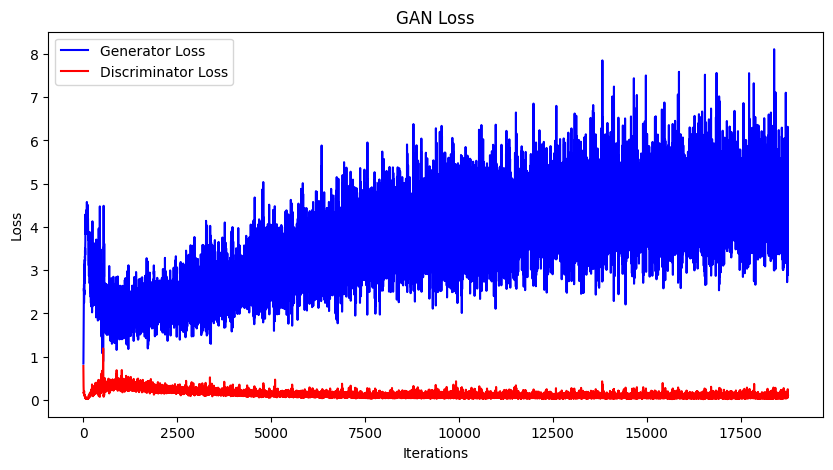

In [83]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label="Generator Loss", color='blue')
plt.plot(losses_d, label="Discriminator Loss", color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Loss")
plt.legend() 
plt.show()